In [1]:
import os
import numpy as np
import random
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

from astropy.table import Table
from astropy.visualization import ZScaleInterval

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)
zscale = ZScaleInterval()

In [3]:
def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType)

def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
                             skymap=None, cutoutSideLength=51, **kwargs):
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)
    if skymap is None:
        skymap = butler.get("%s_skyMap" % datasetType)
     # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)
    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filter}
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    return cutout_image

In [4]:
def make_cutout_image(butler, ra, dec, filter='r', vmin=None, vmax=None, label=None,
                      show=True, saveplot=False, savefits=False,
                      datasetType='deepCoadd'):
    cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter=filter, datasetType='deepCoadd')
    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    if vmin is None or vmax is None:
        vmin, vmax = zscale.get_limits(cutout_image.image.array)

    plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    plt.colorbar()
    plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(),
                color='none', edgecolor='red', marker='o', s=200)
    if label is not None:
        plt.title(label)
    if saveplot:
        if isinstance(saveplot, str):
            filename = saveplot
        else:
            filename = 'postage-stamp.png'
        plt.savefig(filename)
    if show:
        plt.show()

    return cutout_image

In [5]:
%store -r bright_objects_filtered_idx01
%store -r bright_objects_filtered_ra01
%store -r bright_objects_filtered_dec01

%store -r bright_objects_filtered_idx11
%store -r bright_objects_filtered_ra11
%store -r bright_objects_filtered_dec11

In [6]:
bright_objects_filtered_idx01 = np.array(bright_objects_filtered_idx01).tolist()
bright_objects_filtered_ra01 = np.array(bright_objects_filtered_ra01).tolist()
bright_objects_filtered_dec01 = np.array(bright_objects_filtered_dec01).tolist()

bright_objects_filtered_idx11 = np.array(bright_objects_filtered_idx11).tolist()
bright_objects_filtered_ra11 = np.array(bright_objects_filtered_ra11).tolist()
bright_objects_filtered_dec11 = np.array(bright_objects_filtered_dec11).tolist()

In [7]:
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dafPersist.Butler(repo)

In [8]:
bright_objects_table01 = Table([bright_objects_filtered_idx01,
                              bright_objects_filtered_ra01,
                              bright_objects_filtered_dec01], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})

bright_objects_table11 = Table([bright_objects_filtered_idx11,
                              bright_objects_filtered_ra11,
                              bright_objects_filtered_dec11], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table11'})

print(bright_objects_table01)
print(bright_objects_table11)

   ID         RA           DEC      
------- ------------- --------------
1088655 54.4383166191 -31.1298833316
2145918 57.9184954941 -30.1313293125
2277505 57.4602505509  -30.830219855
2277506 57.4596961063 -30.8323130295
2533493  52.831392662 -28.6296455411
4575148 57.3845422834 -28.5006819493
   ID         RA           DEC      
------- ------------- --------------
4314350 57.7644346146  -28.982537467
4364427 57.6628579471  -29.716851566
4316725 57.8867046706 -28.9128925493
4233721 57.9142509622 -29.3763920767
6702211 57.8799363561 -28.0408589036
6708563 57.8670964859 -28.0525248209
4316670 57.8695407955 -28.9156036078
6751199 57.8048775125 -27.7452681853
2621106 52.5279054843  -28.580178199
2547100 52.6326248266 -28.4008575942
    ...           ...            ...
5498348 52.5771996429 -27.6627260694
5429674 52.6699902232 -27.5846079156
5412510 52.7205499781 -27.9167566054
3518463  56.328285215 -29.4336767916
5937249 54.2819471871   -27.78272504
 754834 55.4242866771 -30.8184187033
4

In [9]:
subfolder = 'Stamps'
if not os.path.exists(subfolder):
    os.mkdir(subfolder)

In [19]:
random_bright_table11 = Table([[0], [float(0)], [float(0)]], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})
count = 0
while count < 5:
    row = random.choice(bright_objects_table11)
    random_bright_table11.add_row(row)
    count+=1
random_bright_table11.remove_row(0)
print(random_bright_table11)

   ID         RA           DEC      
------- ------------- --------------
3703403 55.8804892596 -29.2969790261
5414584 52.7603041178 -27.8696734805
5008705 53.8929762842 -28.1605774715
1262297 54.2229937741  -29.833480352
5596426 55.2510850472 -28.1962551481


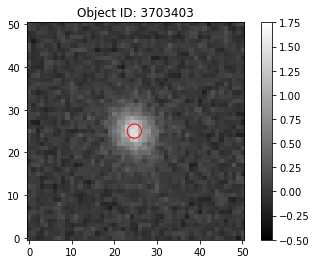

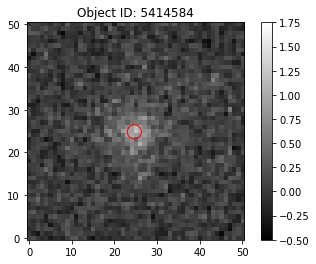

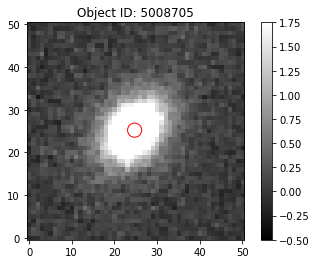

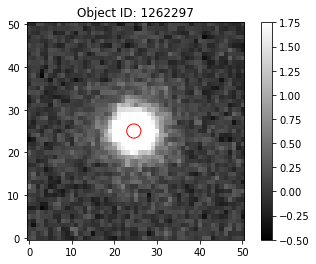

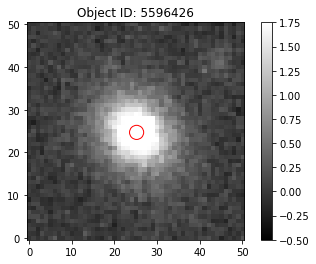

In [40]:
frame = 1
vmin, vmax = -0.5, +1.75
filter = 'u'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in random_bright_table11:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)

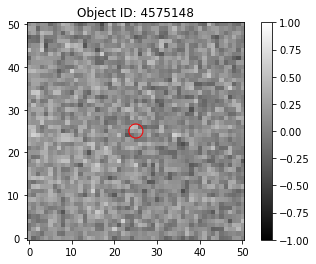

In [25]:
frame = 1
vmin, vmax = -1, +1
filter = 'u'
show = True
saveplot = False

make_cutout_image(butler, 57.3845422834, -28.5006819493, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % 4575148,
                      show=show, saveplot=saveplot)

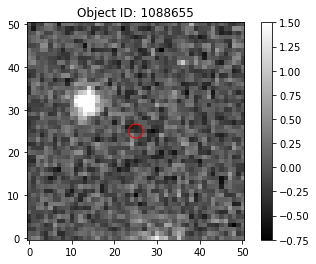

NoResults: No locations for get: datasetType:deepCoadd_sub dataId:DataId(initialdata={'tract': 4640, 'patch': '4,5', 'filter': 'r', 'bbox': Box2I(minimum=Point2I(17505, 23067), dimensions=Extent2I(51, 51))}, tag=set())

In [15]:
frame = 1
vmin, vmax = -0.75, +1.5
filter = 'r'
show = True
datasetType = 'deepCoadd'

for objectId, ra, dec in bright_objects_table01:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)